# PixelCNN for FashionMNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp

from flax import struct
from flax import linen as nn
from flax.training import train_state

import optax
from clu import metrics

## 0. Training Parameters

In [2]:
IMAGE_SIZE = 16
CHANNELS = 1
PIXEL_LEVELS = 8
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 64
EPOCHS = 100
LR = 1e-3

## 1. Preparing FashionMNIST dataset

In [3]:
# Turn input image into pixels and per-pixel labels
def preprocess(imgs):
    imgs = imgs['image']
    imgs_int = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE))
    imgs_int = tf.cast((imgs_int / (256 / PIXEL_LEVELS)), tf.int32)
    imgs = tf.cast(imgs_int, tf.float32)
    imgs = imgs / PIXEL_LEVELS
    return {'image': imgs, 'label': imgs_int}

# Get train/valid datasets
def get_datasets():
    train_ds, valid_ds = tfds.load('fashion_mnist', split=['train', 'test'])
    
    train_ds = train_ds.map(lambda sample: preprocess(sample))
    valid_ds = valid_ds.map(lambda sample: preprocess(sample))
    
    train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(1)
    valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(1)
    return train_ds, valid_ds

Images:


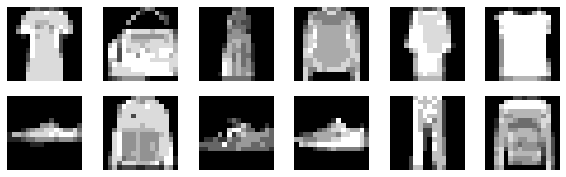

Labels


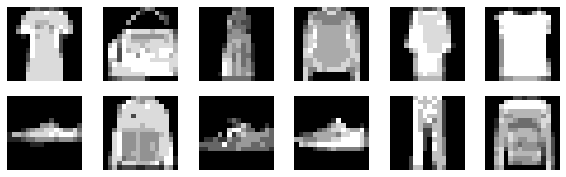

In [4]:
# Check dataset
def plot_imgs(batch, num_rows=2, num_cols=6):
    plt.figure(figsize=(10, 3))
    for i in range(num_cols * num_rows):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.axis('off')
        ax.imshow(batch[i], cmap='gray')
    plt.show()

test_ds, _ = get_datasets()
test_batch = next(test_ds.as_numpy_iterator())
print('Images:')
plot_imgs(test_batch['image'])
print('Labels')
plot_imgs(test_batch['label'])

## 2. Build the PixelCNN

In [5]:
class MaskedConv2D(nn.Module):
    features: int # The number of output features
    kernel_size: tuple
    mask_type: str
    padding: str

    @nn.compact
    def __call__(self, x):
        in_channels = x.shape[-1]
        assert self.mask_type in ['A', 'B'], 'Mask type should be either A or B'
        kh, kw = self.kernel_size
        
        mask = np.ones(shape=(kh, kw, in_channels, self.features))
        mask[kh // 2 + 1:,] = 0
        mask[kh // 2, kw // 2 + 1: ,] = 0
        if self.mask_type == 'A':
            mask[kh // 2, kw // 2, ] = 0

        x = nn.Conv(features=self.features, 
                    kernel_size=self.kernel_size, 
                    kernel_dilation=1,
                    strides=1,
                    padding=self.padding, mask=mask)(x)
        return x

In [6]:
# # check masked conv
# masked_conv = MaskedConv2D(128, (7, 7), 'A', 'SAME')
# print(masked_conv.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 16, 16, 1))))

In [7]:
# Building the residual block
class ResidualBlock(nn.Module):

    features:int
    
    @nn.compact
    def __call__(self, x):

        cx = nn.Conv(features=self.features//2, 
                     kernel_size=(1, 1), 
                     kernel_dilation=1, 
                     strides=1)(x)
        cx = nn.relu(cx)

        cx = MaskedConv2D(features=self.features//2,
                          kernel_size=(3, 3),
                          mask_type='B',
                          padding='SAME')(cx)
        cx = nn.relu(cx)

        cx = nn.Conv(features=self.features,
                     kernel_size=(1, 1),
                     kernel_dilation=1,
                     strides=1)(cx)
        x = nn.relu(cx + x)

        return x

In [8]:
# Check residual block
# res_block = ResidualBlock(128) 
# print(res_block.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 16, 16, 128))))

In [9]:
class PixelCNN(nn.Module):

    features:int
    num_res_blocks:int
    output_size:int
    num_conv_b:int=2
    output_channels:int=1

    @nn.compact
    def __call__(self, x):
        
        # Masked Conv 1
        x = MaskedConv2D(features=self.features,
                         kernel_size=(7, 7),
                         mask_type='A',
                         padding='SAME')(x)
        x = nn.relu(x)

        # Residual blocks
        for _ in range(self.num_res_blocks):
            x = ResidualBlock(self.features)(x)

        # Masked Conv 2
        for _ in range(self.num_conv_b):
            x = MaskedConv2D(features=self.features,
                             kernel_size=(1, 1),
                             mask_type='B',
                             padding='SAME')(x)
            x = nn.relu(x)

        # Output conv
        x = nn.Conv(features=self.output_size,
                    kernel_size=(1, 1),
                    kernel_dilation=1,
                    strides=1,
                    padding='SAME')(x)

        
        return x.reshape(x.shape[0], x.shape[1], x.shape[2], self.output_channels, -1)

In [10]:
# check PixelCNN model
pixel_cnn = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS, PIXEL_LEVELS)
print(pixel_cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 16, 16, 1)), depth=2,
                         console_kwargs={'width': 110}))


                                               PixelCNN Summary                                               
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                 ┃ module        ┃ inputs               ┃ outputs              ┃ params                ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│                      │ PixelCNN      │ float32[1,16,16,1]   │ float32[1,16,16,1,8] │                       │
├──────────────────────┼───────────────┼──────────────────────┼──────────────────────┼───────────────────────┤
│ MaskedConv2D_0       │ MaskedConv2D  │ float32[1,16,16,1]   │ float32[1,16,16,128] │                       │
├──────────────────────┼───────────────┼──────────────────────┼──────────────────────┼───────────────────────┤
│ MaskedConv2D_0/Conv… │ Conv          │ float32[1,16,16,1]   │ float32[1,16,16,128] │ bias: float32[128]    │


## 3. Functions for `Train State`

In [11]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(model, param_key, learning_rate):
    # initialize model parameters
    params = model.init(param_key, jnp.ones((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))['params']
    # initialize optimizer
    tx = optax.adam(learning_rate=LR)
    return TrainState.create(
                apply_fn=model.apply,
                params=params,
                tx=tx,
                metrics=Metrics.empty())

## 4. Train step functions

In [12]:
# Train step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        preds = state.apply_fn({'params': params}, batch['image'])
        loss = optax.softmax_cross_entropy_with_integer_labels(preds, batch['label']).mean()
        return loss

    # compute loss and apply gradients
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    # update metrics
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    
    return state

    
# Validation
@jax.jit
def validation(state, batch):
    preds = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(preds, batch['label']).mean()

    # update metrics
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [13]:
# Function for sequential image generation
@jax.jit
def model_output_probs(state, imgs):
    preds = state.apply_fn({'params': state.params}, imgs)
    return nn.softmax(preds)


def sample_from(probs, temperature):
    probs = np.array(probs, dtype=float) # Avoid numpy's "probs do not sum to 1 problem"
    probs = probs ** (1.0 / temperature)
    probs /= probs.sum()
    return np.random.choice(len(probs), p=probs)


def generate_imgs(state, temperature, num_imgs):

    output_imgs = np.zeros((num_imgs, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    batch, rows, cols, channels = output_imgs.shape

    for row in range(rows):
        for col in range(cols):
            for channel in range(channels):
                preds = model_output_probs(state, output_imgs)[:, row, col, channel]
                output_imgs[:, row, col, channel] = [sample_from(x, temperature) for x in preds]
                output_imgs[:, row, col, channel] /= PIXEL_LEVELS
    return output_imgs

## 5. Training

In [14]:
train_ds, valid_ds = get_datasets()
pixel_cnn = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS, PIXEL_LEVELS)
state = create_train_state(pixel_cnn, jax.random.PRNGKey(0), learning_rate=LR)

Epoch   1	Time:0.12 min
	Train loss: 0.7062  Valid loss: 0.6204
Epoch   5	Time:0.06 min
	Train loss: 0.5787  Valid loss: 0.5783
Epoch  10	Time:0.06 min
	Train loss: 0.5605  Valid loss: 0.5684
Epoch  15	Time:0.06 min
	Train loss: 0.5521  Valid loss: 0.5558
Epoch  20	Time:0.06 min
	Train loss: 0.5470  Valid loss: 0.5533


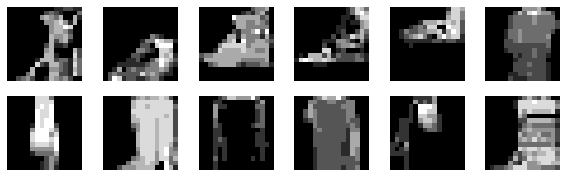

Epoch  25	Time:0.06 min
	Train loss: 0.5434  Valid loss: 0.5501
Epoch  30	Time:0.06 min
	Train loss: 0.5406  Valid loss: 0.5495
Epoch  35	Time:0.06 min
	Train loss: 0.5386  Valid loss: 0.5503
Epoch  40	Time:0.06 min
	Train loss: 0.5371  Valid loss: 0.5486


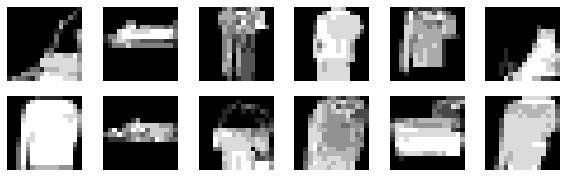

Epoch  45	Time:0.06 min
	Train loss: 0.5361  Valid loss: 0.5475
Epoch  50	Time:0.06 min
	Train loss: 0.5349  Valid loss: 0.5472
Epoch  55	Time:0.06 min
	Train loss: 0.5339  Valid loss: 0.5465
Epoch  60	Time:0.06 min
	Train loss: 0.5333  Valid loss: 0.5454


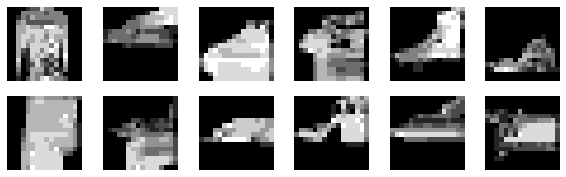

Epoch  65	Time:0.06 min
	Train loss: 0.5325  Valid loss: 0.5470
Epoch  70	Time:0.06 min
	Train loss: 0.5319  Valid loss: 0.5459
Epoch  75	Time:0.06 min
	Train loss: 0.5314  Valid loss: 0.5488
Epoch  80	Time:0.06 min
	Train loss: 0.5309  Valid loss: 0.5512


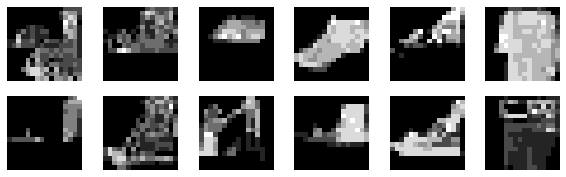

Epoch  85	Time:0.06 min
	Train loss: 0.5302  Valid loss: 0.5493
Epoch  90	Time:0.06 min
	Train loss: 0.5301  Valid loss: 0.5466
Epoch  95	Time:0.06 min
	Train loss: 0.5296  Valid loss: 0.5446
Epoch 100	Time:0.06 min
	Train loss: 0.5292  Valid loss: 0.5462


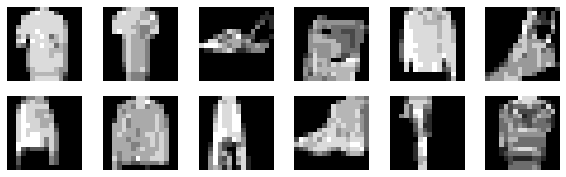

In [15]:
for i in range(EPOCHS):

    prev_time = time.time()
    
    # training
    for batch in train_ds.as_numpy_iterator():
        state = train_step(state, batch)
    
    train_loss = state.metrics.compute()['loss']
    state = state.replace(metrics=state.metrics.empty())

    # validation
    test_state = state
    for batch in valid_ds.as_numpy_iterator():
        test_state = validation(test_state, batch)

    valid_loss = test_state.metrics.compute()['loss']

    curr_time = time.time()
    if i == 0 or (i + 1) % 5 == 0:
        print(f'Epoch {i+1:3d}\tTime:{(curr_time - prev_time) / 60:.2f} min')
        print(f'\tTrain loss: {train_loss:.4f}  Valid loss: {valid_loss:.4f}')
    
    if (i + 1) % 20 == 0:
        output_imgs = generate_imgs(state, 1.0, 12)
        plot_imgs(output_imgs)
    

## 5. Generate Images

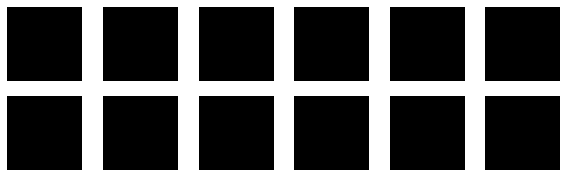

In [16]:
# With temperature = 0.1 (more deterministic)
output_imgs = generate_imgs(state, 0.1, 12)
plot_imgs(output_imgs)

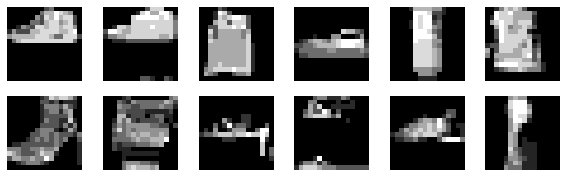

In [17]:
# With temperature = 1.0 
output_imgs = generate_imgs(state, 1.0, 12)
plot_imgs(output_imgs)